### 1. Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample, class_weight
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
from numpy import mean
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

In [2]:
pd.set_option('display.max_rows', None)  # Set to None for displaying all rows
pd.set_option('display.max_columns', None)  # Set to None for displaying all columns

### 2. Reading and visualizing the dataset

##### a. Reading the csv

In [3]:
df = pd.read_csv('gtd.csv', encoding='latin-1')
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.46,-69.95,1.00,0,NaN,NaN,1,1,1,0.00,NaN,NaN,0.00,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.00,Named Civilian,NaN,Julio Guzman,58.00,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.37,-99.09,1.00,0,NaN,NaN,1,1,1,0.00,NaN,NaN,0.00,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.00,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.00,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0,7.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,1.00,1.00,0.00,NaN,NaN,NaN,Mexico,1.00,800000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.48,120.60,4.00,0,NaN,NaN,1,1,1,0.00,NaN,NaN,0.00,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.00,Radio Journalist/Staff/Facility,Voice of America,Employee,217.00,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,38.00,23.76,1.00,0,NaN,NaN,1,1,1,0.00,NaN,NaN,0.00,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.00,Embassy/Consulate,NaN,U.S. Embassy,217.00,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.00,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,

##### b. Filtering only African countries

In [4]:
african_countries = [
    "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", 
    "Cameroon", "Central African Republic", "Chad", "Comoros", "Democratic Republic of the Congo", 
    "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", 
    "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", 
    "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", 
    "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", 
    "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", "South Sudan", "Sudan", 
    "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"
]

# Filtering the DataFrame to select only African countries
africa_df = df[df['country_txt'].isin(african_countries)]

In [5]:
africa_df['attacktype1_txt'].value_counts()

attacktype1_txt
Bombing/Explosion                      8785
Armed Assault                          8133
Assassination                          2506
Hostage Taking (Kidnapping)            2479
Unknown                                1690
Facility/Infrastructure Attack         1028
Hijacking                               185
Hostage Taking (Barricade Incident)     115
Unarmed Assault                          94
Name: count, dtype: int64

In [6]:
africa_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25015 entries, 16 to 181686
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 26.0+ MB


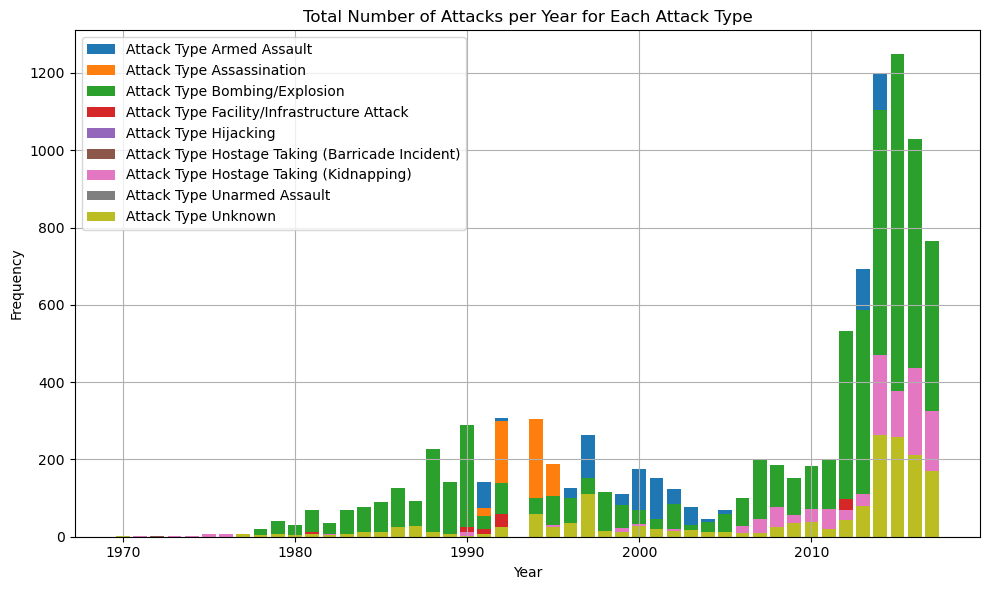

In [7]:
# Grouping by 'iyear' and 'attacktype1', then aggregating the counts
yearly_attack_counts = africa_df.groupby(['iyear', 'attacktype1_txt']).size().reset_index(name='frequency')

# Plotting the bar graph
plt.figure(figsize=(10, 6))

for attack_type, data in yearly_attack_counts.groupby('attacktype1_txt'):
    plt.bar(data['iyear'], data['frequency'], label=f'Attack Type {attack_type}')

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Total Number of Attacks per Year for Each Attack Type')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

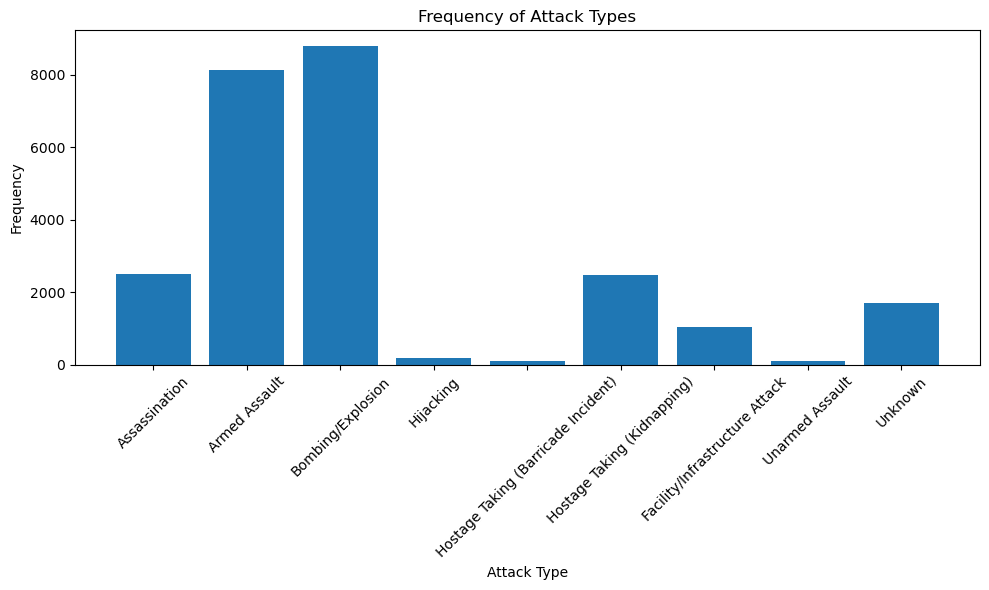

In [8]:
# Grouping by 'attacktype1' and 'attacktype1_txt', then aggregating the counts
attacktype_counts = africa_df.groupby(['attacktype1', 'attacktype1_txt']).size().reset_index(name='frequency')

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(attacktype_counts['attacktype1_txt'], attacktype_counts['frequency'])

plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.title('Frequency of Attack Types')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
africa_df.isnull().sum()

eventid                   0
iyear                     0
imonth                    0
iday                      0
approxdate            23712
extended                  0
resolution            24722
country                   0
country_txt               0
region                    0
region_txt                0
provstate                65
city                      9
latitude                688
longitude               689
specificity               1
vicinity                  0
location              16991
summary                5778
crit1                     0
crit2                     0
crit3                     0
doubtterr                 0
alternative           20330
alternative_txt       20330
multiple                  0
success                   0
suicide                   0
attacktype1               0
attacktype1_txt           0
attacktype2           22882
attacktype2_txt       22882
attacktype3           24810
attacktype3_txt       24810
targtype1                 0
targtype1_txt       

##### c. Filter out specific columns to work on based on domain knowledge

In [10]:
selected_columns = [
    'iyear', 'imonth', 'iday', 'latitude', 'longitude', 'country',
    'country_txt', 'region', 'region_txt', 'provstate', 'city', 'multiple',
    'success', 'suicide', 'targtype1','targtype1_txt', 'weaptype1',
    'weaptype1_txt', 'gname', 'attacktype1_txt', 'attacktype1', 'target1',
    'natlty1', 'natlty1_txt', 'nkill', 'property', 'dbsource'
]

# Creating a new DataFrame with selected columns
attack_type_df = africa_df[selected_columns]

In [11]:
attack_type_df.head()

,iyear,imonth,iday,latitude,longitude,country,country_txt,region,region_txt,provstate,city,multiple,success,suicide,targtype1,targtype1_txt,weaptype1,weaptype1_txt,gname,attacktype1_txt,attacktype1,target1,natlty1,natlty1_txt,nkill,property,dbsource
16,1970,1,11,NaN,NaN,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,4,Military,13,Unknown,Eritrean Liberation Front,Unknown,9,Soldier,217.00,United States,1.00,0,PGIS
132,1970,3,14,NaN,NaN,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,10,Journalists & Media,13,Unknown,Eritrean Liberation Front,Hostage Taking (Kidnapping),6,Film crew,422.00,International,0.00,0,PGIS
133,1970,3,14,31.20,29.92,60,Egypt,10,Middle East & North Africa,Alexandria,Alexandria,0.00,1,0,6,Airports & Aircraft,6,Explosives,Unknown,Bombing/Explosion,3,United Arab Airlines Flight Antonov 24 Acft,60.00,Egypt,0.00,1,PGIS
165,1970,4,0,NaN,NaN,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,7,Government (Diplomatic),13,Unknown,Eritrean Liberation Front,Hostage Taking (Kidnapping),6,"Jack Fry, peace corps official",217.00,United States,0.00,0,PGIS
668,1971,1,15,NaN,NaN,230,Zambia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,2,Government (General),13,Unknown,Revolutionary Committee of Mozambique (COREMO),Hostage Taking (Kidnapping),6,members,162.00,Portugal,1.00,0,PGIS


In [12]:
attack_type_df.isnull().sum()

iyear                 0
imonth                0
iday                  0
latitude            688
longitude           689
country               0
country_txt           0
region                0
region_txt            0
provstate            65
city                  9
multiple              0
success               0
suicide               0
targtype1             0
targtype1_txt         0
weaptype1             0
weaptype1_txt         0
gname                 0
attacktype1_txt       0
attacktype1           0
target1              63
natlty1             150
natlty1_txt         150
nkill              1910
property              0
dbsource              0
dtype: int64

### 3. EDA

##### a. Latitude and Longitude 

##### a.1. First let's fill in the latitude and longitude

In [13]:
# Grouping by 'country_txt' and checking for null values in 'latitude' and 'longitude' columns
null_lat_long = africa_df.groupby('country_txt')[['latitude', 'longitude']].apply(lambda x: x.isnull().sum()).reset_index()

# Filtering rows where there are null values for latitude or longitude
countries_with_nulls = null_lat_long[(null_lat_long['latitude'] > 0) | (null_lat_long['longitude'] > 0)]

# Displaying countries with null values in latitude or longitude
print(countries_with_nulls)

                         country_txt  latitude  longitude
0                            Algeria       126        126
1                             Angola        34         34
2                              Benin         1          1
3                           Botswana         1          1
4                       Burkina Faso         1          1
5                            Burundi        23         23
6                           Cameroon        10         10
7           Central African Republic        17         17
8                               Chad        14         14
10  Democratic Republic of the Congo         7          7
11                          Djibouti         1          1
12                             Egypt        21         21
13                 Equatorial Guinea         1          1
14                           Eritrea         4          4
15                          Ethiopia        20         20
18                             Ghana         2          3
21            

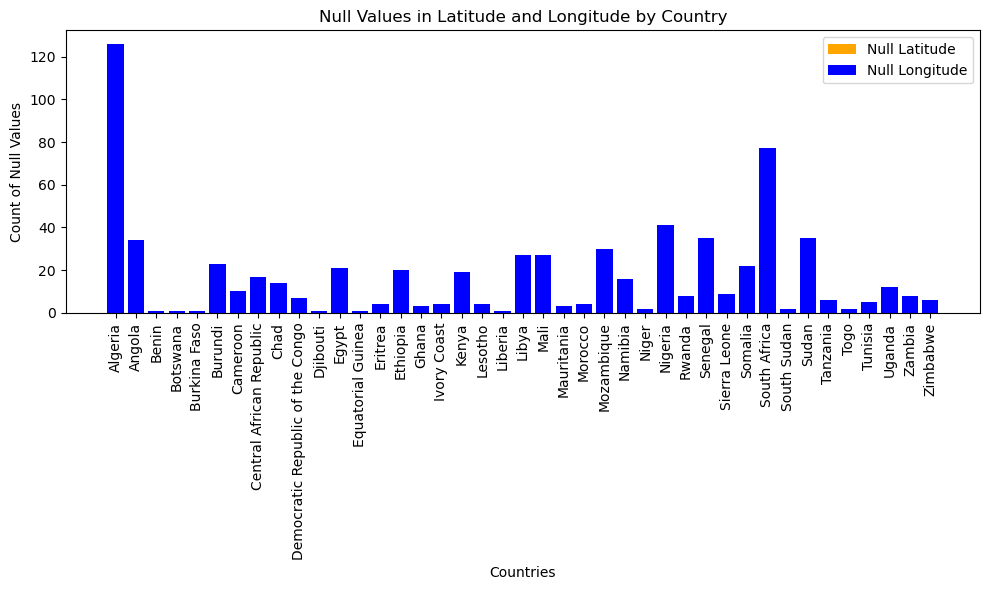

In [14]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(countries_with_nulls['country_txt'], countries_with_nulls['latitude'], label='Null Latitude', color='orange')
plt.bar(countries_with_nulls['country_txt'], countries_with_nulls['longitude'], label='Null Longitude', color='blue')

plt.xlabel('Countries')
plt.ylabel('Count of Null Values')
plt.title('Null Values in Latitude and Longitude by Country')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

We take the avg by countries for the latitude and longitude. This will take the avg area where it would likely happen. We could have dropped the null columns but opted for this approach after consideration. Also, we didn't take the highest frequncy by country because that would further create more biases. 

In [15]:
# Calculate average latitude and longitude by country
avg_lat_long = attack_type_df.groupby('country_txt')[['latitude', 'longitude']].mean().reset_index()

# Merge the averages back to the original dataframe and fill null values
attack_type_df = attack_type_df.merge(avg_lat_long, on='country_txt', suffixes=('', '_avg'))

# Fill null values in latitude and longitude columns with the calculated averages
attack_type_df['latitude'].fillna(attack_type_df['latitude_avg'], inplace=True)
attack_type_df['longitude'].fillna(attack_type_df['longitude_avg'], inplace=True)

# Drop the auxiliary columns used for calculation
attack_type_df.drop(columns=['latitude_avg', 'longitude_avg'], inplace=True)

In [16]:
attack_type_df.isnull().sum()

iyear                 0
imonth                0
iday                  0
latitude              0
longitude             0
country               0
country_txt           0
region                0
region_txt            0
provstate            65
city                  9
multiple              0
success               0
suicide               0
targtype1             0
targtype1_txt         0
weaptype1             0
weaptype1_txt         0
gname                 0
attacktype1_txt       0
attacktype1           0
target1              63
natlty1             150
natlty1_txt         150
nkill              1910
property              0
dbsource              0
dtype: int64

##### a.2. Visualization over Africa

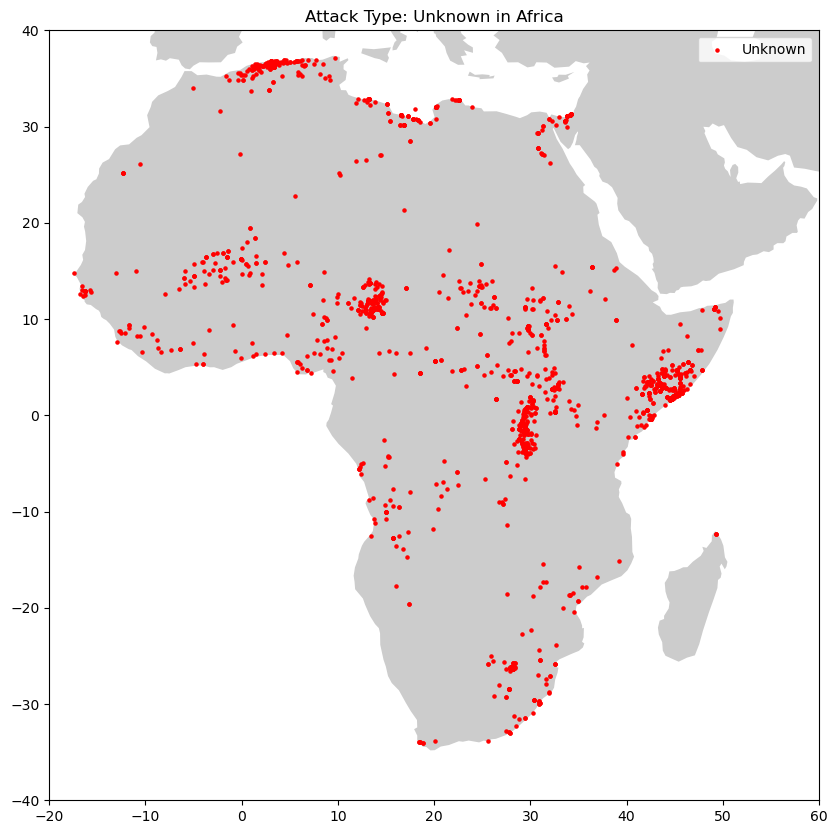

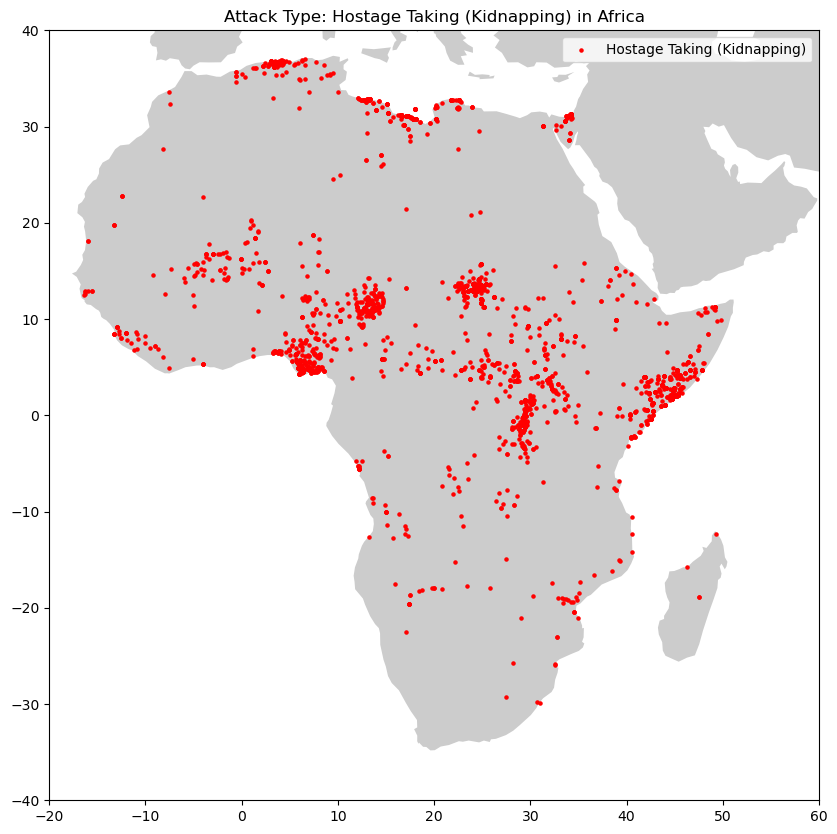

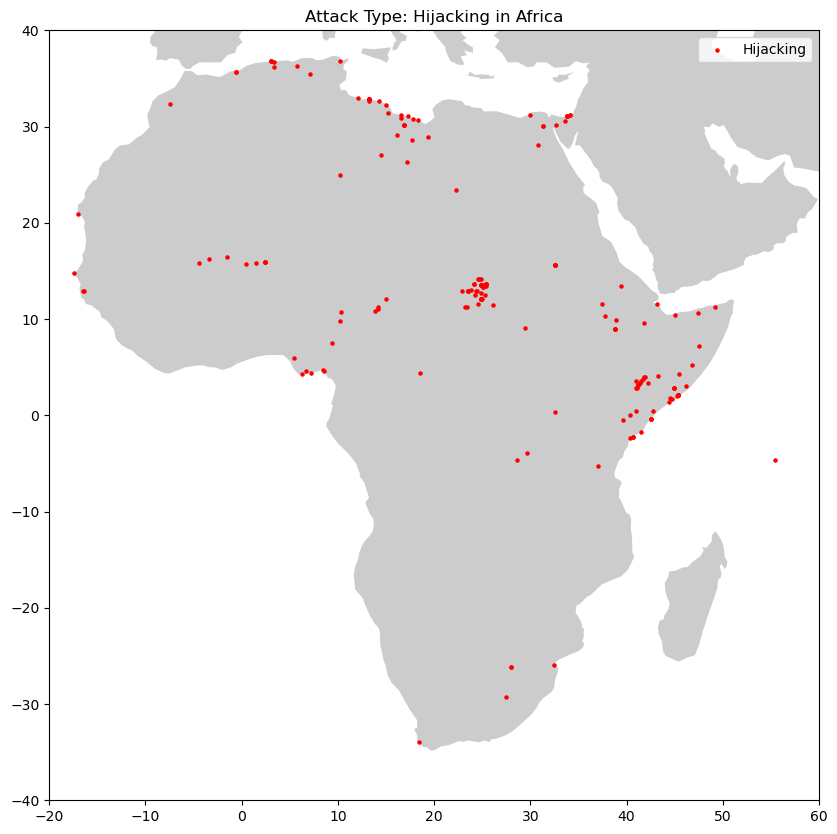

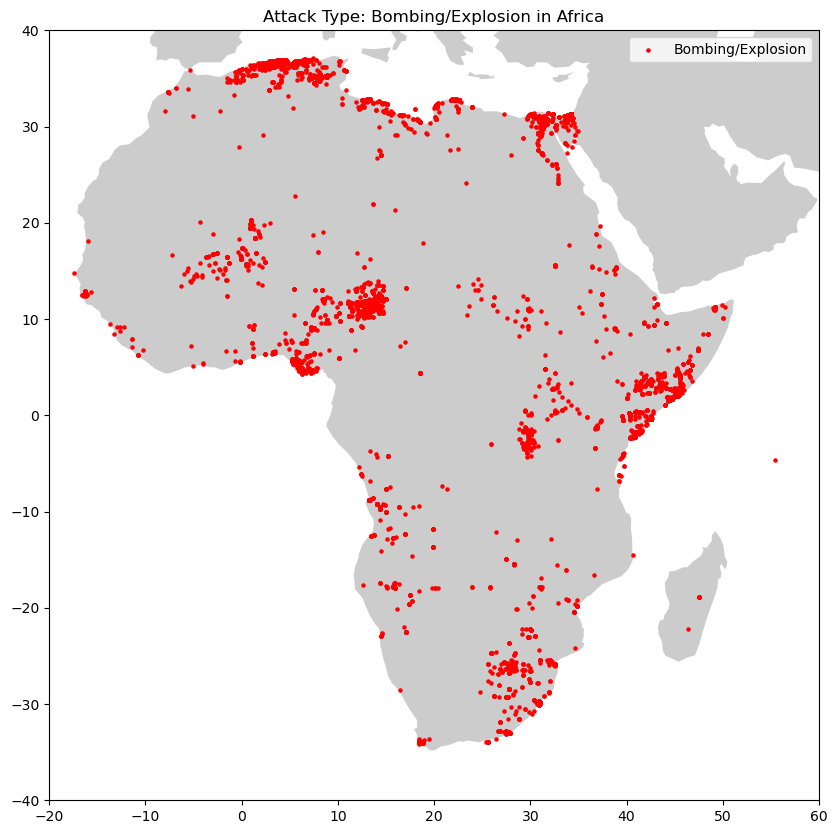

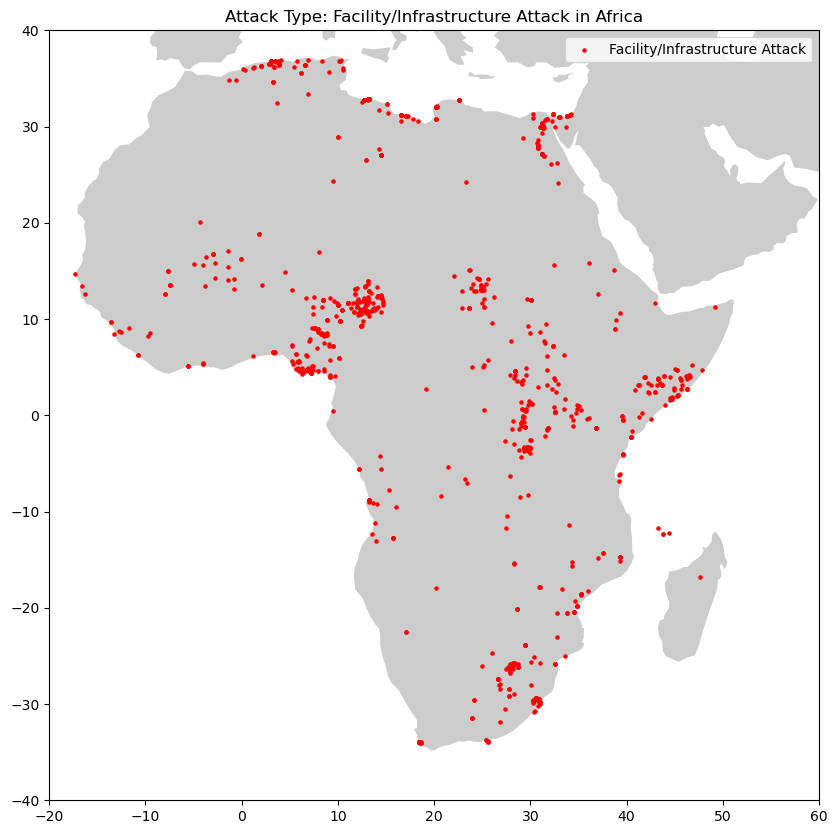

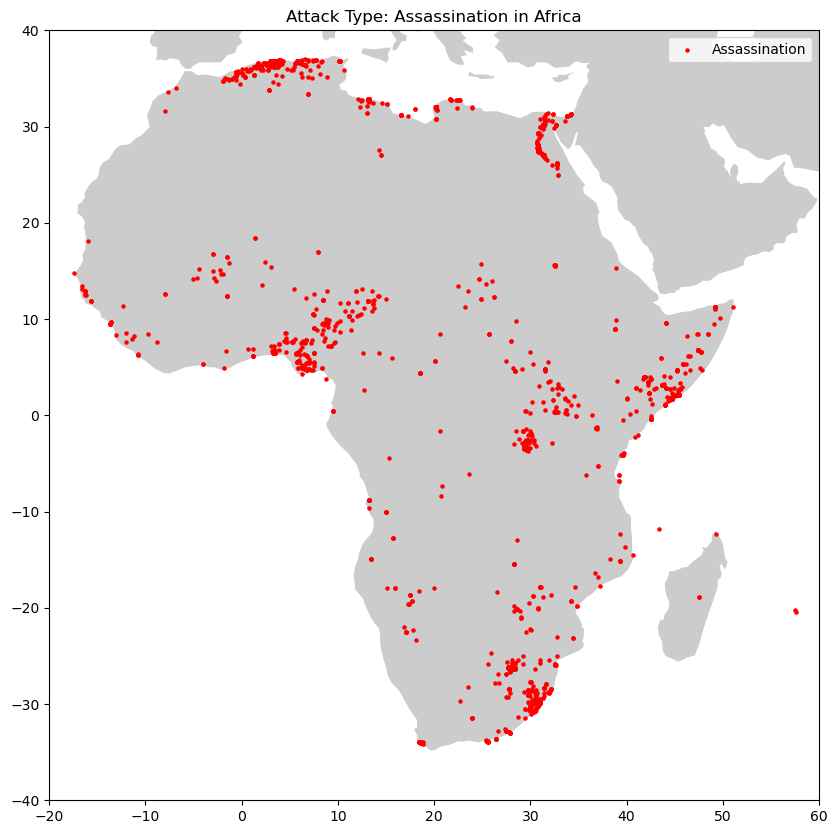

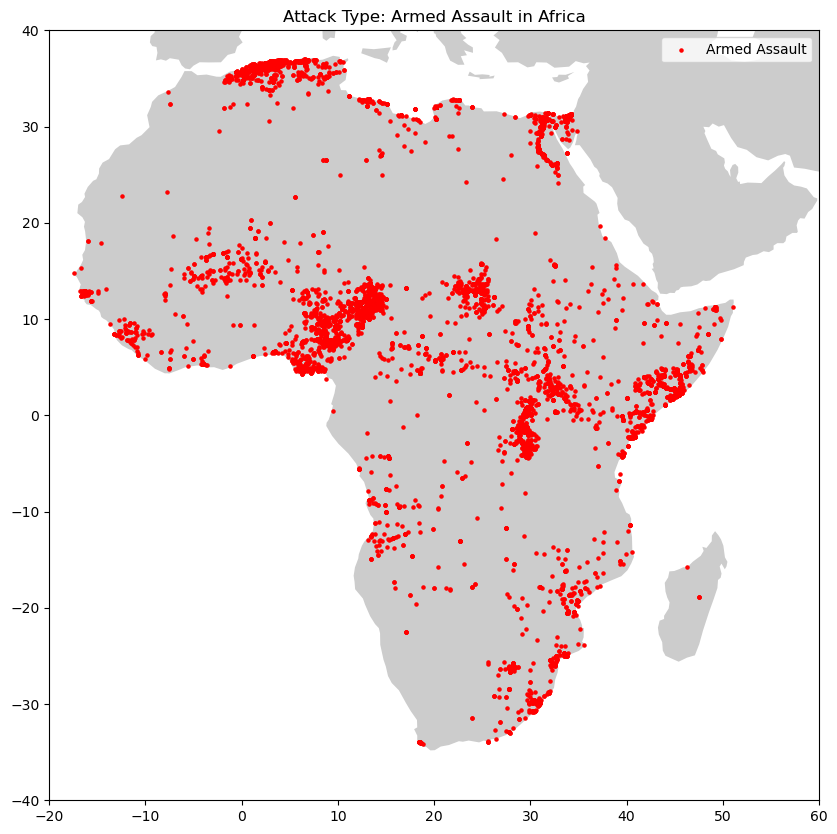

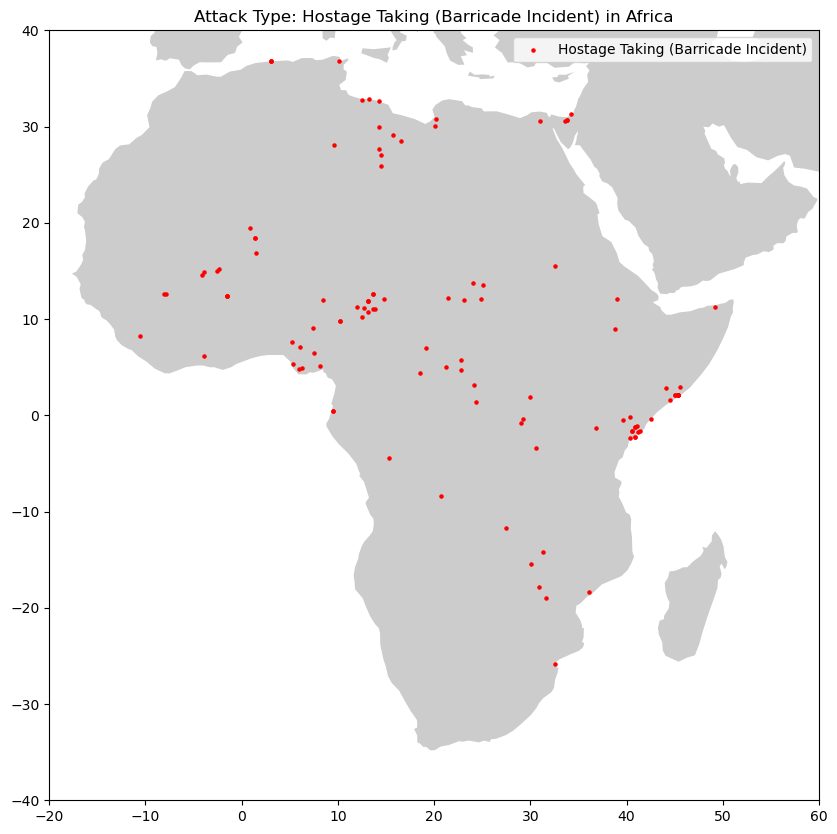

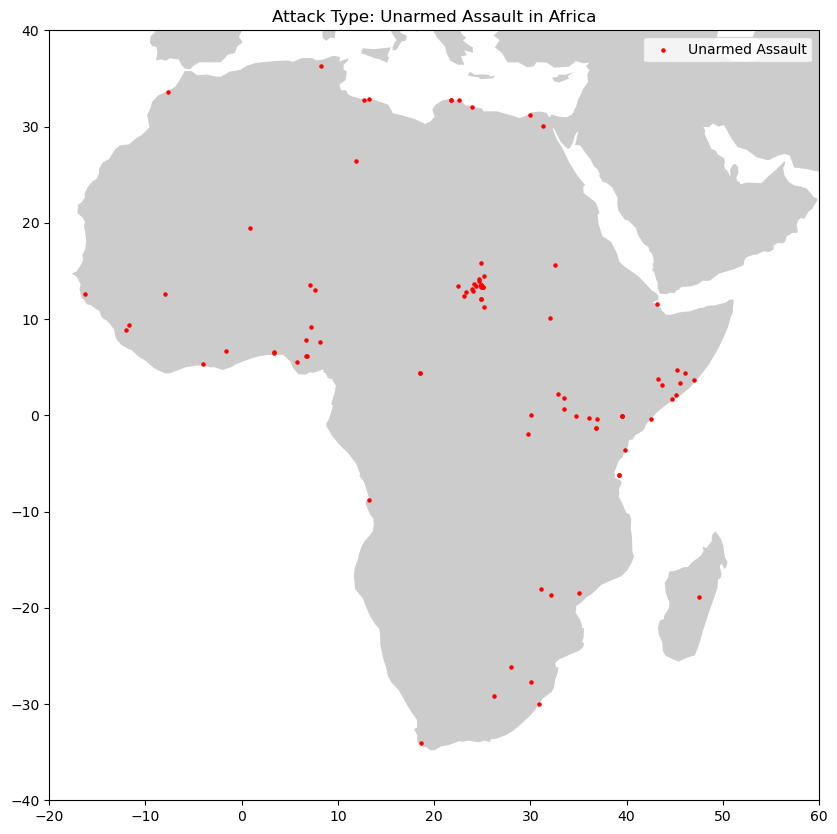

In [17]:
# Create separate GeoDataFrames for each attack type
attack_types = attack_type_df['attacktype1_txt'].unique()

# Load a shapefile for Africa (you'll need a shapefile for the African countries)
# Replace 'path_to_shapefile' with the path to your shapefile
africa_map = gpd.read_file('world.shx')

# Plotting each attack type on separate maps with Africa focus
for attack_type in attack_types:
    # Filter data for the current attack type
    filtered_data = attack_type_df[attack_type_df['attacktype1_txt'] == attack_type]
    
    # Create a GeoDataFrame for the current attack type based on longitude and latitude
    geometry = gpd.points_from_xy(filtered_data.longitude, filtered_data.latitude)
    geo_data = gpd.GeoDataFrame(filtered_data, geometry=geometry)
    
    # Plotting the current attack type on a separate map
    fig, ax = plt.subplots(figsize=(10, 10))
    africa_map.plot(ax=ax, alpha=0.4, color='grey')  # Plot the base map
    geo_data.plot(ax=ax, markersize=5, label=attack_type, color='red')  # Plot the current attack type
    ax.set_xlim([-20, 60])  # Longitude range for Africa
    ax.set_ylim([-40, 40])  # Latitude range for Africa
    plt.legend()
    plt.title(f'Attack Type: {attack_type} in Africa')
    plt.show()

##### b. Dealing with other null columns

In [18]:
attack_type_df.head()

,iyear,imonth,iday,latitude,longitude,country,country_txt,region,region_txt,provstate,city,multiple,success,suicide,targtype1,targtype1_txt,weaptype1,weaptype1_txt,gname,attacktype1_txt,attacktype1,target1,natlty1,natlty1_txt,nkill,property,dbsource
0,1970,1,11,9.86,38.89,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,4,Military,13,Unknown,Eritrean Liberation Front,Unknown,9,Soldier,217.00,United States,1.00,0,PGIS
1,1970,3,14,9.86,38.89,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,10,Journalists & Media,13,Unknown,Eritrean Liberation Front,Hostage Taking (Kidnapping),6,Film crew,422.00,International,0.00,0,PGIS
2,1970,4,0,9.86,38.89,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,0.00,1,0,7,Government (Diplomatic),13,Unknown,Eritrean Liberation Front,Hostage Taking (Kidnapping),6,"Jack Fry, peace corps official",217.00,United States,0.00,0,PGIS
3,1971,1,22,11.58,37.40,65,Ethiopia,11,Sub-Saharan Africa,Amhara,Bahar Dar,0.00,1,0,6,Airports & Aircraft,13,Unknown,Eritrean Liberation Front,Hijacking,4,DC-3,65.00,Ethiopia,0.00,0,Hijacking DB
4,1973,1,23,15.03,39.78,65,Ethiopia,11,Sub-Saharan Africa,Eritrea,Unknown,0.00,1,0,1,Business,13,Unknown,Eritrean Liberation Front,Hostage Taking (Kidnapping),6,businessmen,98.00,Italy,0.00,0,PGIS


##### b.1. For nkill - group by the city and take the average of the nkill columns

In [19]:
# Calculate average nkill by country
avg_nkill = attack_type_df.groupby('country_txt')['nkill'].mean().reset_index()

# Merge the averages back to the original DataFrame and fill null values
attack_type_df = attack_type_df.merge(avg_nkill, on='country_txt', suffixes=('', '_avg'))

# Fill null values in the 'nkill' column with the calculated averages
attack_type_df['nkill'].fillna(attack_type_df['nkill_avg'], inplace=True)

# Drop the auxiliary column used for calculation
attack_type_df.drop(columns=['nkill_avg'], inplace=True)

##### b.2. Remove the provstate and city since the it has less datapoints and further more will tangle with latitude and logitude logic

In [20]:
# Drop rows where 'provstate' or 'city' is null in attack_type_df
attack_type_df.dropna(subset=['provstate', 'city'], inplace=True)

In [21]:
attack_type_df.isnull().sum()

iyear                0
imonth               0
iday                 0
latitude             0
longitude            0
country              0
country_txt          0
region               0
region_txt           0
provstate            0
city                 0
multiple             0
success              0
suicide              0
targtype1            0
targtype1_txt        0
weaptype1            0
weaptype1_txt        0
gname                0
attacktype1_txt      0
attacktype1          0
target1             62
natlty1            150
natlty1_txt        150
nkill                0
property             0
dbsource             0
dtype: int64

##### b.3. For target1, natlty1, natlty1_txt

After careful consideration, we decided to drop target1 as it already had 'Unknown' and replace the natlty1, natlty1_txt with 'Unknown' as a new value for the null columns 

In [22]:
# Remove 'target1' column with null values
attack_type_df.dropna(subset=['target1'], inplace=True)

# Replace null values in 'natlty1' and 'natlty1_txt' columns with 'Unknown'
attack_type_df['natlty1'].fillna('Unknown', inplace=True)
attack_type_df['natlty1_txt'].fillna('Unknown', inplace=True)

In [23]:
attack_type_df.isnull().sum()

iyear              0
imonth             0
iday               0
latitude           0
longitude          0
country            0
country_txt        0
region             0
region_txt         0
provstate          0
city               0
multiple           0
success            0
suicide            0
targtype1          0
targtype1_txt      0
weaptype1          0
weaptype1_txt      0
gname              0
attacktype1_txt    0
attacktype1        0
target1            0
natlty1            0
natlty1_txt        0
nkill              0
property           0
dbsource           0
dtype: int64

##### c. Visualize the data

In [24]:
attack_type_df.dtypes

iyear                int64
imonth               int64
iday                 int64
latitude           float64
longitude          float64
country              int64
country_txt         object
region               int64
region_txt          object
provstate           object
city                object
multiple           float64
success              int64
suicide              int64
targtype1            int64
targtype1_txt       object
weaptype1            int64
weaptype1_txt       object
gname               object
attacktype1_txt     object
attacktype1          int64
target1             object
natlty1             object
natlty1_txt         object
nkill              float64
property             int64
dbsource            object
dtype: object

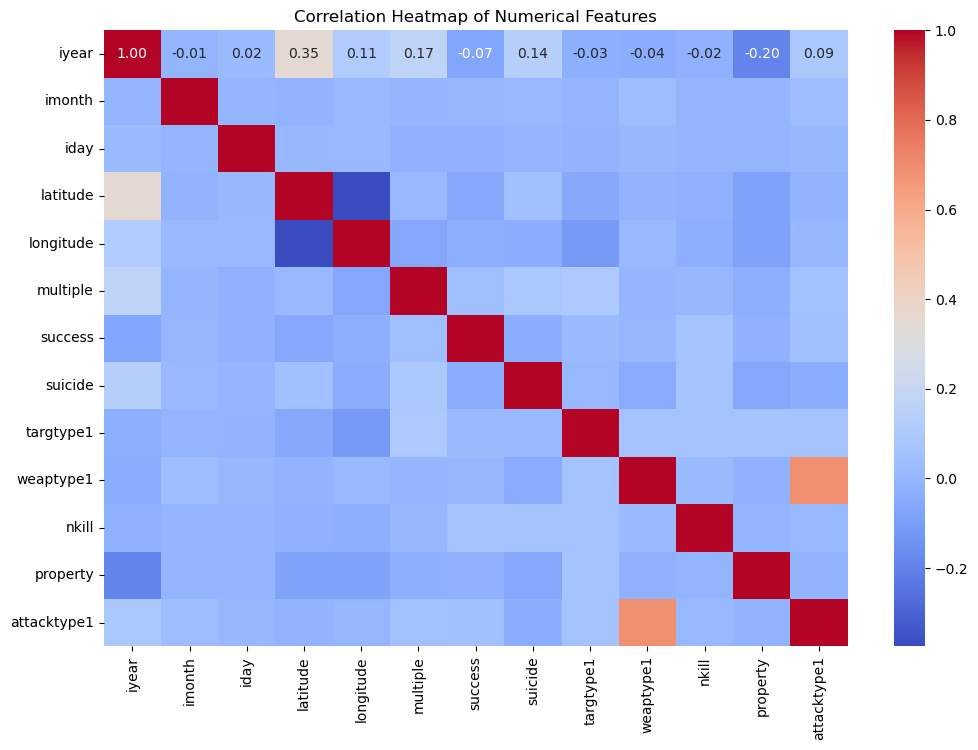

In [25]:
# Select numerical columns for correlation analysis
numerical_cols = ['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'multiple', 'success', 'suicide', 'targtype1', 'weaptype1', 'nkill', 'property', 'attacktype1']

# Create a correlation matrix
corr_matrix = attack_type_df[numerical_cols].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 4. Pre-processing the data

##### a. converting categorical to numeric

In [26]:
attack_type_df.dtypes

iyear                int64
imonth               int64
iday                 int64
latitude           float64
longitude          float64
country              int64
country_txt         object
region               int64
region_txt          object
provstate           object
city                object
multiple           float64
success              int64
suicide              int64
targtype1            int64
targtype1_txt       object
weaptype1            int64
weaptype1_txt       object
gname               object
attacktype1_txt     object
attacktype1          int64
target1             object
natlty1             object
natlty1_txt         object
nkill              float64
property             int64
dbsource            object
dtype: object

In [27]:
print(attack_type_df.columns)

Index(['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'country',
       'country_txt', 'region', 'region_txt', 'provstate', 'city', 'multiple',
       'success', 'suicide', 'targtype1', 'targtype1_txt', 'weaptype1',
       'weaptype1_txt', 'gname', 'attacktype1_txt', 'attacktype1', 'target1',
       'natlty1', 'natlty1_txt', 'nkill', 'property', 'dbsource'],
      dtype='object')


In [28]:
# Selecting categorical columns for label encoding
categorical_cols_high_cardinality = ['provstate', 'city', 'gname', 'target1', 'natlty1', 'natlty1_txt']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the selected columns
for col in categorical_cols_high_cardinality:
    attack_type_df[col + '_encoded'] = label_encoder.fit_transform(attack_type_df[col].astype(str))

# Drop the original categorical columns
attack_type_df.drop(columns=categorical_cols_high_cardinality, inplace=True)

# Verify the encoded DataFrame
attack_type_df.head()

,iyear,imonth,iday,latitude,longitude,country,country_txt,region,region_txt,multiple,success,suicide,targtype1,targtype1_txt,weaptype1,weaptype1_txt,attacktype1_txt,attacktype1,nkill,property,dbsource,provstate_encoded,city_encoded,gname_encoded,target1_encoded,natlty1_encoded,natlty1_txt_encoded
0,1970,1,11,9.86,38.89,65,Ethiopia,11,Sub-Saharan Africa,0.00,1,0,4,Military,13,Unknown,Unknown,9,1.00,0,PGIS,695,6579,173,8584,71,125
1,1970,3,14,9.86,38.89,65,Ethiopia,11,Sub-Saharan Africa,0.00,1,0,10,Journalists & Media,13,Unknown,Hostage Taking (Kidnapping),6,0.00,0,PGIS,695,6579,173,4196,97,51
2,1970,4,0,9.86,38.89,65,Ethiopia,11,Sub-Saharan Africa,0.00,1,0,7,Government (Diplomatic),13,Unknown,Hostage Taking (Kidnapping),6,0.00,0,PGIS,695,6579,173,5393,71,125
3,1971,1,22,11.58,37.40,65,Ethiopia,11,Sub-Saharan Africa,0.00,1,0,6,Airports & Aircraft,13,Unknown,Hijacking,4,0.00,0,Hijacking DB,32,650,173,3471,113,37
4,1973,1,23,15.03,39.78,65,Ethiopia,11,Sub-Saharan Africa,0.00,1,0,1,Business,13,Unknown,Hostage Taking (Kidnapping),6,0.00,0,PGIS,215,6579,173,10704,131,56


In [29]:
attack_type_df.dtypes

iyear                    int64
imonth                   int64
iday                     int64
latitude               float64
longitude              float64
country                  int64
country_txt             object
region                   int64
region_txt              object
multiple               float64
success                  int64
suicide                  int64
targtype1                int64
targtype1_txt           object
weaptype1                int64
weaptype1_txt           object
attacktype1_txt         object
attacktype1              int64
nkill                  float64
property                 int64
dbsource                object
provstate_encoded        int32
city_encoded             int32
gname_encoded            int32
target1_encoded          int32
natlty1_encoded          int32
natlty1_txt_encoded      int32
dtype: object

In [30]:
# List of object-type columns to be dropped
object_columns_to_drop = ['country_txt', 'region_txt', 'targtype1_txt', 'weaptype1_txt', 'attacktype1_txt']  # Add other columns as needed

# Dropping the object-type columns
attack_type_df.drop(columns=object_columns_to_drop, inplace=True)

# Display the updated DataFrame
attack_type_df.head()

,iyear,imonth,iday,latitude,longitude,country,region,multiple,success,suicide,targtype1,weaptype1,attacktype1,nkill,property,dbsource,provstate_encoded,city_encoded,gname_encoded,target1_encoded,natlty1_encoded,natlty1_txt_encoded
0,1970,1,11,9.86,38.89,65,11,0.00,1,0,4,13,9,1.00,0,PGIS,695,6579,173,8584,71,125
1,1970,3,14,9.86,38.89,65,11,0.00,1,0,10,13,6,0.00,0,PGIS,695,6579,173,4196,97,51
2,1970,4,0,9.86,38.89,65,11,0.00,1,0,7,13,6,0.00,0,PGIS,695,6579,173,5393,71,125
3,1971,1,22,11.58,37.40,65,11,0.00,1,0,6,13,4,0.00,0,Hijacking DB,32,650,173,3471,113,37
4,1973,1,23,15.03,39.78,65,11,0.00,1,0,1,13,6,0.00,0,PGIS,215,6579,173,10704,131,56


In [31]:
# Perform one-hot encoding for 'dbsource' column
one_hot_encoded_dbsource = pd.get_dummies(attack_type_df['dbsource'], prefix='dbsource')

# Concatenate the one-hot encoded 'dbsource' columns to the DataFrame
encoded_df = pd.concat([attack_type_df, one_hot_encoded_dbsource], axis=1)

# Drop the original 'dbsource' column
encoded_df.drop(columns=['dbsource'], inplace=True)

# Rename the columns to remove the 'dbsource_' prefix
encoded_df.columns = encoded_df.columns.str.replace('dbsource_', '')

# Display the updated DataFrame
encoded_df.head()

,iyear,imonth,iday,latitude,longitude,country,region,multiple,success,suicide,targtype1,weaptype1,attacktype1,nkill,property,provstate_encoded,city_encoded,gname_encoded,target1_encoded,natlty1_encoded,natlty1_txt_encoded,CBRN Global Chronology,CETIS,Hijacking DB,ISVG,PGIS,START Primary Collection,Sageman,State Department 1997 Document,UMD Algeria 2010-2012,UMD Assassinations Project,UMD Encyclopedia of World Terrorism 2012,UMD Miscellaneous,UMD Schmid 2012,UMD South Africa
0,1970,1,11,9.86,38.89,65,11,0.00,1,0,4,13,9,1.00,0,695,6579,173,8584,71,125,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,1970,3,14,9.86,38.89,65,11,0.00,1,0,10,13,6,0.00,0,695,6579,173,4196,97,51,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,1970,4,0,9.86,38.89,65,11,0.00,1,0,7,13,6,0.00,0,695,6579,173,5393,71,125,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,1971,1,22,11.58,37.40,65,11,0.00,1,0,6,13,4,0.00,0,32,650,173,3471,113,37,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,1973,1,23,15.03,39.78,65,11,0.00,1,0,1,13,6,0.00,0,215,6579,173,10704,131,56,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [32]:
encoded_df.dtypes

iyear                                         int64
imonth                                        int64
iday                                          int64
latitude                                    float64
longitude                                   float64
country                                       int64
region                                        int64
multiple                                    float64
success                                       int64
suicide                                       int64
targtype1                                     int64
weaptype1                                     int64
attacktype1                                   int64
nkill                                       float64
property                                      int64
provstate_encoded                             int32
city_encoded                                  int32
gname_encoded                                 int32
target1_encoded                               int32
natlty1_enco

### 5. ML model

#### Random Forest Classifier

##### a. Base Model

In [61]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier (you can choose other models as well)
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.73      0.78       495
           2       0.83      0.90      0.86      1635
           3       0.92      0.99      0.95      1736
           4       0.75      0.15      0.24        41
           5       0.75      0.12      0.20        26
           6       0.77      0.60      0.67       469
           7       0.78      0.72      0.74       208
           8       0.71      0.25      0.37        20
           9       0.84      0.84      0.84       346

    accuracy                           0.86      4976
   macro avg       0.80      0.59      0.63      4976
weighted avg       0.85      0.86      0.85      4976

Accuracy: 0.8589228295819936


##### b. After under-sampling

In [220]:
# Define majority and minority class labels
majority_class_labels = [1, 2, 3, 7, 9]
minority_class_labels = [4, 5, 6, 8]

# Separate majority and minority classes
majority_class = data[data['attacktype1'].isin(majority_class_labels)]
minority_class = data[data['attacktype1'].isin(minority_class_labels)]

# Find the minimum number of instances among the majority classes
min_count = min(majority_class['attacktype1'].value_counts())

# Downsample the majority classes to match the minimum count
downsampled_majority = pd.concat([
    resample(group, replace=False, n_samples=min_count, random_state=42)
    for _, group in majority_class.groupby('attacktype1')
])

# Combine minority class and downsampled majority classes
downsampled_data = pd.concat([downsampled_majority, minority_class])

# Separate features and target after undersampling
X_resampled = downsampled_data.drop(columns=['attacktype1'])
y_resampled = downsampled_data['attacktype1']

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           9       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Accuracy: 1.0


##### c. After over-sampling

In [221]:
# Separate features and target
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate the features and target back together for resampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['attacktype1'].isin([1, 2, 3, 7, 9])]
minority_class = train_data[train_data['attacktype1'].isin([4, 5, 6, 8])]

# Upsample minority class to match majority class
upsampled_minority = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match majority class size
                              random_state=42)

# Combine majority class and upsampled minority class
upsampled_data = pd.concat([majority_class, upsampled_minority])

# Separate features and target after upsampling
X_resampled = upsampled_data.drop(columns=['attacktype1'])
y_resampled = upsampled_data['attacktype1']

# Initialize Logistic Regression
model = RandomForestClassifier(random_state=42)

# Train the model on the resampled data
model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.71      0.76       495
           2       0.83      0.87      0.85      1635
           3       0.92      0.98      0.95      1736
           4       0.54      0.17      0.26        41
           5       0.60      0.12      0.19        26
           6       0.70      0.68      0.69       469
           7       0.86      0.65      0.74       208
           8       0.62      0.25      0.36        20
           9       0.86      0.84      0.85       346

    accuracy                           0.85      4976
   macro avg       0.75      0.59      0.63      4976
weighted avg       0.85      0.85      0.85      4976

Accuracy: 0.8514871382636656


##### d. Hyper-parameter tuning

In [222]:
'''from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Train the model with the best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))'''

'from sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid to search\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\n# Initialize the RandomForestClassifier\nmodel = RandomForestClassifier(random_state=42)\n\n# Initialize GridSearchCV\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\n\n# Perform grid search to find the best parameters\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters and best score\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\nprint("Best Parameters:", best_params)\nprint("Best Accuracy:", best_score)\n\n# Train the model with the best parameters\nbest_model = RandomForestClassifier(**best_params, random_state=42)\nbest_model.fit(X_train, y_train)\n\n# Predict on the test set using the best model\ny_pred = best_mod

In [223]:
# Set the best parameters obtained from hyperparameter tuning
best_params = {
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Initialize the RandomForestClassifier with the best parameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)

# Train the model with the best parameters
best_rf_model.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.73      0.78       495
           2       0.82      0.89      0.85      1635
           3       0.92      0.98      0.95      1736
           4       1.00      0.12      0.22        41
           5       0.75      0.12      0.20        26
           6       0.77      0.61      0.68       469
           7       0.81      0.71      0.75       208
           8       0.80      0.20      0.32        20
           9       0.84      0.86      0.85       346

    accuracy                           0.86      4976
   macro avg       0.84      0.58      0.62      4976
weighted avg       0.86      0.86      0.85      4976

Accuracy: 0.857516077170418


#### Lazy Classification

In [181]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

 90%|████████▉ | 26/29 [03:01<00:33, 11.16s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 19903, number of used features: 20
[LightGBM] [Info] Start training from score -2.304245
[LightGBM] [Info] Start training from score -1.126015
[LightGBM] [Info] Start training from score -1.044389
[LightGBM] [Info] Start training from score -4.956983
[LightGBM] [Info] Start training from score -5.409989
[LightGBM] [Info] Start training from score -2.295226
[LightGBM] [Info] Start training from score -3.196665
[LightGBM] [Info] Start training from score -5.594561
[LightGBM] [Info] Start training from score -2.701939


100%|██████████| 29/29 [03:04<00:00,  6.35s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.87               0.63    None      0.86   
BaggingClassifier                  0.83               0.59    None      0.83   
ExtraTreesClassifier               0.86               0.59    None      0.85   
RandomForestClassifier             0.86               0.59    None      0.85   
DecisionTreeClassifier             0.79               0.58    None      0.79   
ExtraTreeClassifier                0.69               0.48    None      0.69   
SVC                                0.77               0.43    None      0.75   
LabelSpreading                     0.60               0.38    None      0.59   
LabelPropagation                   0.60               0.38    None      0.59   
AdaBoostClassifier                 0.46               0.36    None      0.49   
NearestCentroid                    0.34 

#### LGBMClassfier

##### a. Before tuning

In [285]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.78      0.81       495
           2       0.83      0.88      0.86      1635
           3       0.93      0.98      0.96      1736
           4       0.67      0.29      0.41        41
           5       0.50      0.08      0.13        26
           6       0.78      0.63      0.69       469
           7       0.82      0.74      0.78       208
           8       0.64      0.35      0.45        20
           9       0.86      0.89      0.87       346

    accuracy                           0.87      4976
   macro avg       0.76      0.62      0.66      4976
weighted avg       0.86      0.87      0.86      4976

Accuracy: 0.8665594855305466


##### b. After tuning

In [286]:
'''# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [20, 30, 40],  # Adjust values as needed
    'max_depth': [5, 10, 15],    # Adjust values as needed
    'learning_rate': [0.1, 0.01, 0.05],  # Adjust values as needed
    # Add more parameters to tune here...
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(lgbm, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)

# Predict on the test set using the best model
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))'''

'# Separate features and target variable\nX = encoded_df.drop(columns=[\'attacktype1\'])\ny = encoded_df[\'attacktype1\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Define the parameter grid\nparam_grid = {\n    \'num_leaves\': [20, 30, 40],  # Adjust values as needed\n    \'max_depth\': [5, 10, 15],    # Adjust values as needed\n    \'learning_rate\': [0.1, 0.01, 0.05],  # Adjust values as needed\n    # Add more parameters to tune here...\n}\n\n# Initialize the LGBMClassifier\nlgbm = LGBMClassifier(random_state=42)\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(lgbm, param_grid=param_grid, scoring=\'accuracy\', cv=5, verbose=1, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\n# Best parameters found\nprint("Best Parameters:", grid_search.best_params_)\n\n# Predict on the test set using the best model\nbest_lgbm = grid_search.best_estimator_\ny_pred = best_lgbm.predict(X_test)\n\n

In [287]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.79      0.81       495
           2       0.84      0.88      0.86      1635
           3       0.93      0.98      0.96      1736
           4       0.76      0.32      0.45        41
           5       1.00      0.08      0.14        26
           6       0.77      0.64      0.70       469
           7       0.80      0.73      0.76       208
           8       0.64      0.45      0.53        20
           9       0.87      0.88      0.87       346

    accuracy                           0.87      4976
   macro avg       0.83      0.64      0.68      4976
weighted avg       0.86      0.87      0.86      4976

Accuracy: 0.8669614147909968


##### c. Using under-sampling for LGBMClassifier

In [288]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the random under-sampling strategy
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Undersampling the training set
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Fit the model with resampled data
lgbm.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.70      0.61       495
           2       0.82      0.46      0.59      1635
           3       0.92      0.93      0.92      1736
           4       0.12      0.66      0.21        41
           5       0.04      0.46      0.07        26
           6       0.43      0.33      0.37       469
           7       0.55      0.69      0.61       208
           8       0.17      0.90      0.28        20
           9       0.70      0.82      0.75       346

    accuracy                           0.67      4976
   macro avg       0.48      0.66      0.49      4976
weighted avg       0.76      0.67      0.69      4976

Accuracy: 0.6716237942122186


##### d. Using over-sampling for LGBMClassifier

In [289]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the random over-sampling strategy
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Oversampling the training set
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Fit the model with oversampled data
lgbm.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.84      0.79       495
           2       0.87      0.81      0.84      1635
           3       0.94      0.98      0.96      1736
           4       0.63      0.41      0.50        41
           5       0.67      0.15      0.25        26
           6       0.71      0.68      0.70       469
           7       0.75      0.77      0.76       208
           8       0.53      0.40      0.46        20
           9       0.85      0.91      0.88       346

    accuracy                           0.86      4976
   macro avg       0.74      0.66      0.68      4976
weighted avg       0.85      0.86      0.85      4976

Accuracy: 0.8559083601286174


##### e. Combining both under and over sampling techniques

In [290]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the over-sampling and under-sampling strategies
over_sampling_counts = {1: 8740, 2: 8740, 3: 8740}  # Define your over-sampling counts here
under_sampling_counts = {4: 74, 5: 74, 6: 74, 7: 74, 8: 74, 9: 74}  # Adjust under-sampling counts here

over = RandomOverSampler(sampling_strategy=over_sampling_counts)
under = RandomUnderSampler(sampling_strategy=under_sampling_counts)

# Define the pipeline with LGBMClassifier
steps = [('o', over), ('u', under), ('m', LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1))]
pipeline = Pipeline(steps=steps)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.72      0.56       495
           2       0.67      0.75      0.71      1635
           3       0.86      0.87      0.86      1736
           4       0.05      0.10      0.07        41
           5       0.02      0.08      0.03        26
           6       0.34      0.11      0.17       469
           7       0.36      0.22      0.27       208
           8       0.06      0.25      0.10        20
           9       0.64      0.17      0.27       346

    accuracy                           0.65      4976
   macro avg       0.39      0.36      0.34      4976
weighted avg       0.66      0.65      0.64      4976



##### f. Assigning weights

In [291]:
class_frequencies = Counter(y_train)
total_samples = len(y_train)

class_weights = {}
for cls, freq in class_frequencies.items():
    class_weights[cls] = total_samples / (len(class_frequencies) * freq)

# You might want to normalize the weights to a specific range or adjust them for better performance
# Normalize the weights to sum up to a specific value or to the number of classes
sum_weights = sum(class_weights.values())
normalized_weights = {cls: weight / sum_weights for cls, weight in class_weights.items()}

print(normalized_weights)

{1: 0.014309833814590948, 6: 0.014181366478599609, 9: 0.021298606583964205, 3: 0.004059628753511167, 2: 0.004404901594049917, 5: 0.31947909875946306, 7: 0.03493076141227545, 4: 0.2030974270685158, 8: 0.3842383755350299}


In [292]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1, class_weight=normalized_weights)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.74      0.83      0.78       495
           2       0.87      0.80      0.84      1635
           3       0.93      0.98      0.95      1736
           4       0.64      0.44      0.52        41
           5       0.57      0.15      0.24        26
           6       0.69      0.68      0.69       469
           7       0.77      0.81      0.79       208
           8       0.44      0.55      0.49        20
           9       0.86      0.90      0.88       346

    accuracy                           0.85      4976
   macro avg       0.72      0.68      0.69      4976
weighted avg       0.85      0.85      0.85      4976

Accuracy: 0.8536977491961415


#### Neural Network

Preprossing all into float before feeding it into neural network

In [63]:
# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train, X_test to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Convert y_train, y_test to float if they are not already in float format
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Now we calculate the class weights

In [64]:
unique_classes = np.unique(y_train)
class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_weights = {}
for class_idx, class_count in enumerate(class_counts):
    class_weight = total_samples / (len(unique_classes) * class_count)
    class_weights[class_idx] = class_weight

class_weights = dict(sorted(class_weights.items()))

In [65]:
print(class_weights)

{0: inf, 1: 1.1129564390762177, 2: 0.34259402702470093, 3: 0.3157402119423821, 4: 15.796031746031746, 5: 24.84769038701623, 6: 1.1029648101967304, 7: 2.7167622167622167, 8: 29.884384384384383, 9: 1.6565126924677487}


In [66]:
unique_classes = np.unique(y_train)
class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_weights = {}
max_weight = 10  # Set a maximum value for the class weight

for class_idx, class_count in enumerate(class_counts):
    class_weight = total_samples / (len(unique_classes) * class_count)
    class_weight = min(class_weight, max_weight)  # Cap weights to a maximum value
    class_weights[class_idx] = class_weight

# Normalize the weights between 0 and 1
max_class_weight = max(class_weights.values())
for class_idx in class_weights:
    class_weights[class_idx] /= max_class_weight

class_weights = dict(sorted(class_weights.items()))

In [67]:
print(class_weights)

{0: 1.0, 1: 0.11129564390762177, 2: 0.03425940270247009, 3: 0.03157402119423821, 4: 1.0, 5: 1.0, 6: 0.11029648101967304, 7: 0.2716762216762217, 8: 1.0, 9: 0.16565126924677487}


In [68]:
class_weights[0] = 0

In [69]:
print(class_weights)

{0: 0, 1: 0.11129564390762177, 2: 0.03425940270247009, 3: 0.03157402119423821, 4: 1.0, 5: 1.0, 6: 0.11029648101967304, 7: 0.2716762216762217, 8: 1.0, 9: 0.16565126924677487}


Adam without class weights

In [72]:
# Assuming y_train_encoded and y_test_encoded contain your encoded labels
y_train_encoded = y_train - 1
y_test_encoded = y_test - 1

# Get the number of unique classes after encoding
num_classes = len(np.unique(y_train_encoded))

# Check if labels in y_train_encoded fall within the valid range
invalid_labels_train = [label for label in y_train_encoded if label < 0 or label >= num_classes]

# Check if labels in y_test_encoded fall within the valid range
invalid_labels_test = [label for label in y_test_encoded if label < 0 or label >= num_classes]

if not invalid_labels_train and not invalid_labels_test:
    print("All labels in y_train and y_test are within the valid range.")
else:
    print("There are invalid labels in y_train or y_test.")
    print("Invalid labels in y_train:", invalid_labels_train)
    print("Invalid labels in y_test:", invalid_labels_test)

All labels in y_train and y_test are within the valid range.


In [73]:
# Check label distribution in y_train and y_test
unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)

print("Unique labels in y_train:", unique_labels_train)
print("Unique labels in y_test:", unique_labels_test)


Unique labels in y_train: [1 2 3 4 5 6 7 8 9]
Unique labels in y_test: [1 2 3 4 5 6 7 8 9]


In [74]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Create a basic neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # num_classes is the total number of unique classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_adjusted, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate model performance on test data
loss, accuracy = model.evaluate(X_test, y_test_adjusted)
print("Test Accuracy:", accuracy)

Epoch 1/10
560/560 [==============================] - 3s 4ms/step - loss: 35.6434 - accuracy: 0.2706 - val_loss: 11.2851 - val_accuracy: 0.2160
Epoch 2/10
560/560 [==============================] - 1s 3ms/step - loss: 10.5436 - accuracy: 0.2882 - val_loss: 8.3727 - val_accuracy: 0.3260
Epoch 3/10
560/560 [==============================] - 1s 3ms/step - loss: 8.5735 - accuracy: 0.2959 - val_loss: 9.0879 - val_accuracy: 0.3009
Epoch 4/10
560/560 [==============================] - 2s 3ms/step - loss: 7.4199 - accuracy: 0.3013 - val_loss: 6.0809 - val_accuracy: 0.2597
Epoch 5/10
560/560 [==============================] - 2s 3ms/step - loss: 6.1069 - accuracy: 0.3186 - val_loss: 7.0087 - val_accuracy: 0.2245
Epoch 6/10
560/560 [==============================] - 2s 3ms/step - loss: 5.9048 - accuracy: 0.3217 - val_loss: 4.6467 - val_accuracy: 0.3491
Epoch 7/10
560/560 [==============================] - 2s 3ms/step - loss: 5.0098 - accuracy: 0.3369 - val_loss: 7.3656 - val_accuracy: 0.3666
Epo

Adam with class weights

In [143]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Create a basic neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # num_classes is the total number of unique classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_adjusted, epochs=10, batch_size=32, validation_split=0.1, class_weight = class_weights)

# Evaluate model performance on test data
loss, accuracy = model.evaluate(X_test, y_test_adjusted)
print("Test Accuracy:", accuracy)

Epoch 1/10
560/560 [==============================] - 7s 11ms/step - loss: 12.5252 - accuracy: 0.1491 - val_loss: 37.0113 - val_accuracy: 0.1467
Epoch 2/10
560/560 [==============================] - 2s 3ms/step - loss: 3.4337 - accuracy: 0.1623 - val_loss: 29.0359 - val_accuracy: 0.1185
Epoch 3/10
560/560 [==============================] - 2s 3ms/step - loss: 2.1460 - accuracy: 0.1778 - val_loss: 21.5211 - val_accuracy: 0.1562
Epoch 4/10
560/560 [==============================] - 2s 3ms/step - loss: 1.7437 - accuracy: 0.1869 - val_loss: 18.8611 - val_accuracy: 0.1728
Epoch 5/10
560/560 [==============================] - 2s 3ms/step - loss: 1.4233 - accuracy: 0.1986 - val_loss: 12.6130 - val_accuracy: 0.1773
Epoch 6/10
560/560 [==============================] - 2s 3ms/step - loss: 1.1217 - accuracy: 0.1961 - val_loss: 5.3770 - val_accuracy: 0.2351
Epoch 7/10
560/560 [==============================] - 2s 3ms/step - loss: 0.4827 - accuracy: 0.1241 - val_loss: 6.8663 - val_accuracy: 0.0723

In [126]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Computed class weights
class_weights = {0: 1.1, 1: 1.1129564390762177, 2: 0.34259402702470093, 3: 0.3157402119423821, 4: 15.796031746031746, 5: 24.84769038701623, 6: 1.1029648101967304, 7: 2.7167622167622167, 8: 29.884384384384383, 9: 1.6565126924677487}

# Create a basic neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # num_classes is the total number of unique classes
])

# Compile the model with adjusted class weights
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

# Train the model with adjusted class weights
history = model.fit(X_train, y_train_adjusted, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate model performance on test data
loss, accuracy = model.evaluate(X_test, y_test_adjusted)
print("Test Accuracy:", accuracy)

C:\Users\Aayush\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
560/560 [==============================] - 4s 7ms/step - loss: 282255486353408.0000 - accuracy: 0.3488 - val_loss: 1.7588 - val_accuracy: 0.3586
Epoch 2/10
560/560 [==============================] - 2s 3ms/step - loss: 1.7146 - accuracy: 0.3512 - val_loss: 1.6539 - val_accuracy: 0.3586
Epoch 3/10
560/560 [==============================] - 1s 3ms/step - loss: 1.6581 - accuracy: 0.3512 - val_loss: 1.6203 - val_accuracy: 0.3586
Epoch 4/10
560/560 [==============================] - 2s 3ms/step - loss: 1.6362 - accuracy: 0.3512 - val_loss: 1.6040 - val_accuracy: 0.3586
Epoch 5/10
560/560 [==============================] - 2s 3ms/step - loss: 1.6242 - accuracy: 0.3512 - val_loss: 1.5941 - val_accuracy: 0.3586
Epoch 6/10
560/560 [==============================] - 2s 3ms/step - loss: 1.6163 - accuracy: 0.3512 - val_loss: 1.5874 - val_accuracy: 0.3586
Epoch 7/10
560/560 [==============================] - 2s 3ms/step - loss: 1.6108 - accuracy: 0.3512 - val_loss: 1.5825 - val_accuracy:

In [128]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Computed class weights
class_weights = {0: 1.1, 1: 1.1129564390762177, 2: 0.34259402702470093, 3: 0.3157402119423821, 4: 15.796031746031746, 5: 24.84769038701623, 6: 1.1029648101967304, 7: 2.7167622167622167, 8: 29.884384384384383, 9: 1.6565126924677487}

# Create a basic neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # num_classes is the total number of unique classes
])

# Compile the model with adjusted class weights
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

# Train the model with adjusted class weights
history = model.fit(X_train, y_train_adjusted, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate model performance on test data
loss, accuracy = model.evaluate(X_test, y_test_adjusted)
print("Test Accuracy:", accuracy)

C:\Users\Aayush\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
560/560 [==============================] - 5s 8ms/step - loss: 72.8904 - accuracy: 0.2622 - val_loss: 28.2724 - val_accuracy: 0.3440
Epoch 2/10
560/560 [==============================] - 2s 3ms/step - loss: 39.6496 - accuracy: 0.2731 - val_loss: 31.2212 - val_accuracy: 0.3536
Epoch 3/10
560/560 [==============================] - 2s 3ms/step - loss: 27.5523 - accuracy: 0.2795 - val_loss: 18.3114 - val_accuracy: 0.3315
Epoch 4/10
560/560 [==============================] - 2s 3ms/step - loss: 20.2175 - accuracy: 0.2796 - val_loss: 8.7471 - val_accuracy: 0.3039
Epoch 5/10
560/560 [==============================] - 2s 3ms/step - loss: 15.3867 - accuracy: 0.2842 - val_loss: 12.5996 - val_accuracy: 0.2506
Epoch 6/10
560/560 [==============================] - 2s 3ms/step - loss: 9.9782 - accuracy: 0.2856 - val_loss: 6.9536 - val_accuracy: 0.1994
Epoch 7/10
560/560 [==============================] - 2s 3ms/step - loss: 4.8085 - accuracy: 0.2509 - val_loss: 2.1217 - val_accuracy: 0.35

### 6. Additional Ideas

##### a. Using selected dates

In [293]:
encoded_df_cut = encoded_df[encoded_df['iyear']>1994]

# Separate features and target variable
X = encoded_df_cut.drop(columns=['attacktype1'])
y = encoded_df_cut['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.67      0.72       311
           2       0.81      0.87      0.84      1434
           3       0.93      0.98      0.95      1392
           4       0.64      0.22      0.33        32
           5       1.00      0.14      0.24        22
           6       0.76      0.60      0.67       463
           7       0.83      0.76      0.79       172
           8       0.38      0.33      0.36        15
           9       0.87      0.91      0.89       298

    accuracy                           0.85      4139
   macro avg       0.78      0.61      0.64      4139
weighted avg       0.85      0.85      0.84      4139

Accuracy: 0.8499637593621647


##### b. Removing the low frequency classes

In [295]:
classes_to_remove = [4, 5, 8]
filtered_df = encoded_df[~encoded_df['attacktype1'].isin(classes_to_remove)]

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.76      0.79       483
           2       0.85      0.89      0.87      1634
           3       0.94      0.97      0.96      1772
           6       0.79      0.63      0.70       469
           7       0.81      0.79      0.80       193
           9       0.87      0.89      0.88       347

    accuracy                           0.88      4898
   macro avg       0.85      0.82      0.83      4898
weighted avg       0.88      0.88      0.88      4898

Accuracy: 0.8789301755818701


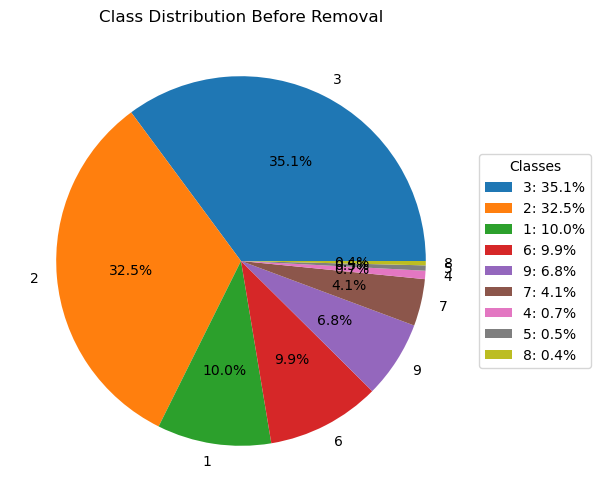

In [301]:
# Calculate class distribution
class_distribution = encoded_df['attacktype1'].value_counts(normalize=True) * 100

# Create the pie chart
sizes = class_distribution.values
labels = class_distribution.index

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Class Distribution Before Removal')

# Add a legend with percentages
plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5), labels=[f"{label}: {size:.1f}%" for label, size in zip(labels, sizes)])
plt.show()


##### c. Running the lazy on the removed set

In [302]:
classes_to_remove = [4, 5, 8]
filtered_df = encoded_df[~encoded_df['attacktype1'].isin(classes_to_remove)]

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

 90%|████████▉ | 26/29 [02:54<00:36, 12.14s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 19591, number of used features: 20
[LightGBM] [Info] Start training from score -2.282423
[LightGBM] [Info] Start training from score -1.110060
[LightGBM] [Info] Start training from score -1.033742
[LightGBM] [Info] Start training from score -2.279426
[LightGBM] [Info] Start training from score -3.162605
[LightGBM] [Info] Start training from score -2.686888


100%|██████████| 29/29 [02:56<00:00,  6.08s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.88               0.82    None      0.87   
RandomForestClassifier             0.87               0.80    None      0.87   
ExtraTreesClassifier               0.87               0.79    None      0.86   
BaggingClassifier                  0.85               0.77    None      0.85   
DecisionTreeClassifier             0.79               0.74    None      0.80   
ExtraTreeClassifier                0.72               0.65    None      0.72   
SVC                                0.78               0.64    None      0.77   
AdaBoostClassifier                 0.72               0.60    None      0.71   
LabelSpreading                     0.60               0.55    None      0.60   
LabelPropagation                   0.60               0.55    None      0.60   
KNeighborsClassifier               0.61 

##### d. Tuning the model and running

In [305]:
'''classes_to_remove = [4, 5, 8]
filtered_df = encoded_df[~encoded_df['attacktype1'].isin(classes_to_remove)]

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [20, 30, 40],  # Adjust values as needed
    'max_depth': [5, 10, 15],    # Adjust values as needed
    'learning_rate': [0.1, 0.01, 0.05],  # Adjust values as needed
    # Add more parameters to tune here...
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(lgbm, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)

# Predict on the test set using the best model
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))'''

'classes_to_remove = [4, 5, 8]\nfiltered_df = encoded_df[~encoded_df[\'attacktype1\'].isin(classes_to_remove)]\n\n# Separate features and target variable\nX = filtered_df.drop(columns=[\'attacktype1\'])\ny = filtered_df[\'attacktype1\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Define the parameter grid\nparam_grid = {\n    \'num_leaves\': [20, 30, 40],  # Adjust values as needed\n    \'max_depth\': [5, 10, 15],    # Adjust values as needed\n    \'learning_rate\': [0.1, 0.01, 0.05],  # Adjust values as needed\n    # Add more parameters to tune here...\n}\n\n# Initialize the LGBMClassifier\nlgbm = LGBMClassifier(random_state=42)\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(lgbm, param_grid=param_grid, scoring=\'accuracy\', cv=5, verbose=1, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\n# Best parameters found\nprint("Best Parameters:", grid_search.best_params_)\n\n# Predict on

In [304]:
classes_to_remove = [4, 5, 8]
filtered_df = encoded_df[~encoded_df['attacktype1'].isin(classes_to_remove)]

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.76      0.79       483
           2       0.85      0.89      0.87      1634
           3       0.94      0.97      0.96      1772
           6       0.79      0.63      0.70       469
           7       0.81      0.79      0.80       193
           9       0.87      0.89      0.88       347

    accuracy                           0.88      4898
   macro avg       0.85      0.82      0.83      4898
weighted avg       0.88      0.88      0.88      4898

Accuracy: 0.8789301755818701


##### e. Checking removed classes with neural network

In [77]:
classes_to_remove = [4, 5, 8]
filtered_df = encoded_df[~encoded_df['attacktype1'].isin(classes_to_remove)]

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train, X_test to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Convert y_train, y_test to float if they are not already in float format
y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Create a basic neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # num_classes is the total number of unique classes
])

# Compile the model with adjusted class weights
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

# Train the model with adjusted class weights
history = model.fit(X_train, y_train_adjusted, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate model performance on test data
loss, accuracy = model.evaluate(X_test, y_test_adjusted)
print("Test Accuracy:", accuracy)

Epoch 1/100
551/551 [==============================] - 2s 3ms/step - loss: 92.0277 - accuracy: 0.2678 - val_loss: 49.5077 - val_accuracy: 0.2944
Epoch 2/100
551/551 [==============================] - 1s 2ms/step - loss: 55.8897 - accuracy: 0.2767 - val_loss: 35.2780 - val_accuracy: 0.3337
Epoch 3/100
551/551 [==============================] - 1s 2ms/step - loss: 42.3562 - accuracy: 0.2804 - val_loss: 22.0585 - val_accuracy: 0.2092
Epoch 4/100
551/551 [==============================] - 1s 2ms/step - loss: 29.9354 - accuracy: 0.2924 - val_loss: 22.2932 - val_accuracy: 0.3031
Epoch 5/100
551/551 [==============================] - 2s 3ms/step - loss: 21.1039 - accuracy: 0.2755 - val_loss: 15.8557 - val_accuracy: 0.3628
Epoch 6/100
551/551 [==============================] - 1s 3ms/step - loss: 13.7696 - accuracy: 0.2853 - val_loss: 13.7967 - val_accuracy: 0.1408
Epoch 7/100
551/551 [==============================] - 2s 3ms/step - loss: 9.3100 - accuracy: 0.2544 - val_loss: 5.2024 - val_accu

##### f. Using classes as unkown

In [33]:
# Remove low frequency classes
classes_to_switch = [4, 5, 8]
encoded_df.loc[encoded_df['attacktype1'].isin(classes_to_switch), 'attacktype1'] = 9

# Separate features and target variable
X = encoded_df.drop(columns=['attacktype1'])
y = encoded_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.78      0.81       495
           2       0.83      0.88      0.86      1635
           3       0.93      0.98      0.96      1736
           6       0.78      0.64      0.70       469
           7       0.82      0.72      0.77       208
           9       0.85      0.76      0.81       433

    accuracy                           0.87      4976
   macro avg       0.84      0.79      0.82      4976
weighted avg       0.86      0.87      0.86      4976

Accuracy: 0.8665594855305466


##### g. Checking for any data-leakage 

In [35]:
# List of columns that might lead to data leakage or contain future information
leakage_columns = [
    'CBRN Global Chronology', 'CETIS', 'Hijacking DB', 'ISVG', 'PGIS',
    'START Primary Collection', 'Sageman', 'State Department 1997 Document',
    'UMD Algeria 2010-2012', 'UMD Assassinations Project',
    'UMD Encyclopedia of World Terrorism 2012', 'UMD Miscellaneous',
    'UMD Schmid 2012', 'UMD South Africa'
]

# Exclude potential leakage columns from your dataset
filtered_df = encoded_df.drop(columns=leakage_columns)

# Remove low frequency classes
classes_to_switch = [4, 5, 8]
filtered_df.loc[filtered_df['attacktype1'].isin(classes_to_switch), 'attacktype1'] = 9

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.78      0.81       495
           2       0.84      0.88      0.86      1635
           3       0.93      0.98      0.96      1736
           6       0.79      0.63      0.70       469
           7       0.84      0.74      0.78       208
           9       0.86      0.78      0.82       433

    accuracy                           0.87      4976
   macro avg       0.85      0.80      0.82      4976
weighted avg       0.87      0.87      0.87      4976

Accuracy: 0.8689710610932476


Training Set Metrics:
              precision    recall  f1-score   support

           1       0.96      0.93      0.94      1987
           2       0.95      0.96      0.95      6455
           3       0.97      1.00      0.98      7004
           6       0.97      0.87      0.92      2005
           7       0.99      0.99      0.99       814
           9       0.99      0.98      0.98      1638

    accuracy                           0.96     19903
   macro avg       0.97      0.95      0.96     19903
weighted avg       0.96      0.96      0.96     19903

Testing Set Metrics:
              precision    recall  f1-score   support

           1       0.84      0.78      0.81       495
           2       0.84      0.88      0.86      1635
           3       0.93      0.98      0.96      1736
           6       0.79      0.63      0.70       469
           7       0.84      0.74      0.78       208
           9       0.86      0.78      0.82       433

    accuracy                      

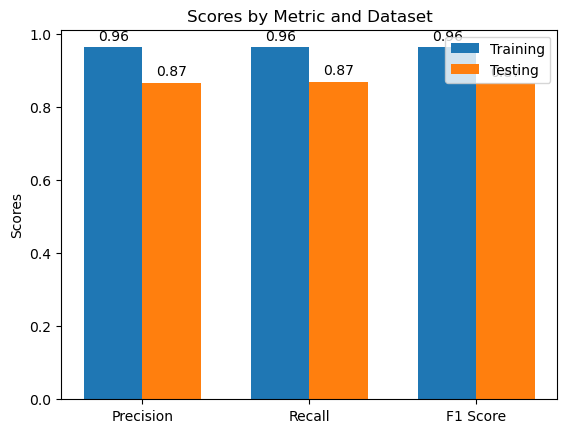

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# List of columns that might lead to data leakage or contain future information
leakage_columns = [
    'CBRN Global Chronology', 'CETIS', 'Hijacking DB', 'ISVG', 'PGIS',
    'START Primary Collection', 'Sageman', 'State Department 1997 Document',
    'UMD Algeria 2010-2012', 'UMD Assassinations Project',
    'UMD Encyclopedia of World Terrorism 2012', 'UMD Miscellaneous',
    'UMD Schmid 2012', 'UMD South Africa'
]

# Exclude potential leakage columns from your dataset
filtered_df = encoded_df.drop(columns=leakage_columns)

# Remove low frequency classes
classes_to_switch = [4, 5, 8]
filtered_df.loc[filtered_df['attacktype1'].isin(classes_to_switch), 'attacktype1'] = 9

# Separate features and target variable
X = filtered_df.drop(columns=['attacktype1'])
y = filtered_df['attacktype1']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

# Train the model
lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred_test = lgbm.predict(X_test)

# Predict on the training set for comparison
y_pred_train = lgbm.predict(X_train)

# Calculate precision, recall, and F1 scores for training and testing sets
train_scores = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_scores = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

# Extracting metrics
train_precision, train_recall, train_f1, _ = train_scores
test_precision, test_recall, test_f1, _ = test_scores

# Display classification reports
print("Training Set Metrics:")
print(classification_report(y_train, y_pred_train))
print("Testing Set Metrics:")
print(classification_report(y_test, y_pred_test))

# Creating bar graph
labels = ['Precision', 'Recall', 'F1 Score']
train_scores = [train_precision, train_recall, train_f1]
test_scores = [test_precision, test_recall, test_f1]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_scores, width, label='Training')
rects2 = ax.bar([i + width for i in x], test_scores, width, label='Testing')

ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Dataset')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()